In [23]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
import xlrd
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# to be run again to be sure

# temp wee measured between 01.01.1995 and 01.12.2012 6544 days (last month of 2012 not included)

In [5]:
# idx corresponding to the indicies of long/lat in each nc file
temp_df = pd.read_csv("dataset/meta_data/bgr_location.csv")
print(temp_df.shape)
temp_df.head()

(13492, 4)


,proj_id,bgr_long,bgr_lat,idx
0,BB_25470023,13.643609,53.416804,516084
1,BB_25470024,13.643653,53.416793,516084
2,BB_25480025,13.826532,53.452024,518975
3,BB_25480026,13.677407,53.457078,518966
4,BB_25481088,13.821475,53.475857,521135


In [4]:
# paths to all nc files 215 files each for a month from 1995 to 2012
from os import walk
folder_path =  "dataset/temperature/data/"
files= []
for (dirpath, dirnames, filenames) in walk(folder_path):
    files.extend(filenames)
    break
files[:2]

['daily_Project_TRY_air_temperature_mean__TT_200912_daymean.nc',
 'daily_Project_TRY_air_temperature_mean__TT_199602_daymean.nc']

In [7]:
# extract temps in each day of each nc file at the corresponding lat/longfor all months
for file_name in files:
    file_path = folder_path + file_name
    nc = netcdf.NetCDFFile(file_path,'r')
    days = nc.variables["datum"][:]
    for d, day in enumerate(days):
        #if day in unique_dates:
        temp_df[str(day)[:-4]] = nc.variables["temperature"][d,:,:].flatten()[temp_df["idx"]]
temp_df = temp_df[temp_df.columns]
temp_df.head()

KeyboardInterrupt: 

In [22]:
# check the number of days in which the temp measured
print(len(temp_df.columns[4:]))
print((pd.to_datetime("12.01.2012").date() - pd.to_datetime("01.01.1995").date()).days)

6544
6544


In [70]:
# convert str date to datetime
columns =temp_df.columns
new_columns =list(temp_df.columns[:4])
print(columns[:6])
print(new_columns)

Index(['proj_id', 'bgr_long', 'bgr_lat', 'idx', '20091201', '20091202'], dtype='object')
['proj_id', 'bgr_long', 'bgr_lat', 'idx']


In [71]:
for day in columns[4:]:
    d = str(day)#[:-4]
    d = d[:4]+'-'+d[4:6]+"-"+d[6:]
    #print(d)
    d = datetime.fromisoformat(d).date()
    new_columns.append(d)
    #print(d)

temp_df.columns=new_columns 

In [72]:
temp_df.head()

,proj_id,bgr_long,bgr_lat,idx,2009-12-01,2009-12-02,2009-12-03,2009-12-04,2009-12-05,2009-12-06,...,1998-03-22,1998-03-23,1998-03-24,1998-03-25,1998-03-26,1998-03-27,1998-03-28,1998-03-29,1998-03-30,1998-03-31
0,BB_25470023,13.643609,53.416804,516084,48,9,18,6,20,44,...,9,13,3,8,42,58,82,98,94,121
1,BB_25470024,13.643653,53.416793,516084,48,9,18,6,20,44,...,9,13,3,8,42,58,82,98,94,121
2,BB_25480025,13.826532,53.452024,518975,49,9,17,7,21,43,...,9,15,3,7,40,56,83,96,91,122
3,BB_25480026,13.677407,53.457078,518966,47,9,18,7,20,44,...,9,13,3,8,42,57,81,98,94,121
4,BB_25481088,13.821475,53.475857,521135,49,10,17,7,22,43,...,10,15,3,8,40,56,83,96,92,121


In [96]:
just_temp_df =temp_df.copy()
just_temp_df = just_temp_df.drop(labels =["bgr_long","bgr_lat", "idx"], axis =1).set_index("proj_id")
just_temp_df.head()

,2009-12-01,2009-12-02,2009-12-03,2009-12-04,2009-12-05,2009-12-06,2009-12-07,2009-12-08,2009-12-09,2009-12-10,...,1998-03-22,1998-03-23,1998-03-24,1998-03-25,1998-03-26,1998-03-27,1998-03-28,1998-03-29,1998-03-30,1998-03-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,48,9,18,6,20,44,60,30,44,45,...,9,13,3,8,42,58,82,98,94,121
BB_25470024,48,9,18,6,20,44,60,30,44,45,...,9,13,3,8,42,58,82,98,94,121
BB_25480025,49,9,17,7,21,43,61,30,44,46,...,9,15,3,7,40,56,83,96,91,122
BB_25480026,47,9,18,7,20,44,60,31,43,45,...,9,13,3,8,42,57,81,98,94,121
BB_25481088,49,10,17,7,22,43,61,31,44,46,...,10,15,3,8,40,56,83,96,92,121


In [99]:
col = sorted(just_temp_df.columns)
just_temp_df = just_temp_df[col]
just_temp_df.head()

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25470024,14,-8,-26,-63,-65,-80,-76,-56,-19,16,...,46,59,35,48,62,63,65,49,39,15
BB_25480025,17,-6,-27,-67,-63,-80,-74,-52,-19,18,...,44,58,33,49,60,61,64,48,42,19
BB_25480026,14,-8,-28,-65,-65,-81,-77,-56,-20,16,...,46,59,36,49,62,63,65,49,38,15
BB_25481088,17,-6,-26,-66,-62,-80,-74,-52,-19,18,...,44,59,33,49,60,62,64,48,42,19


<AxesSubplot:label='acf59689-c7ad-4e91-93f7-3109f45f1764'>

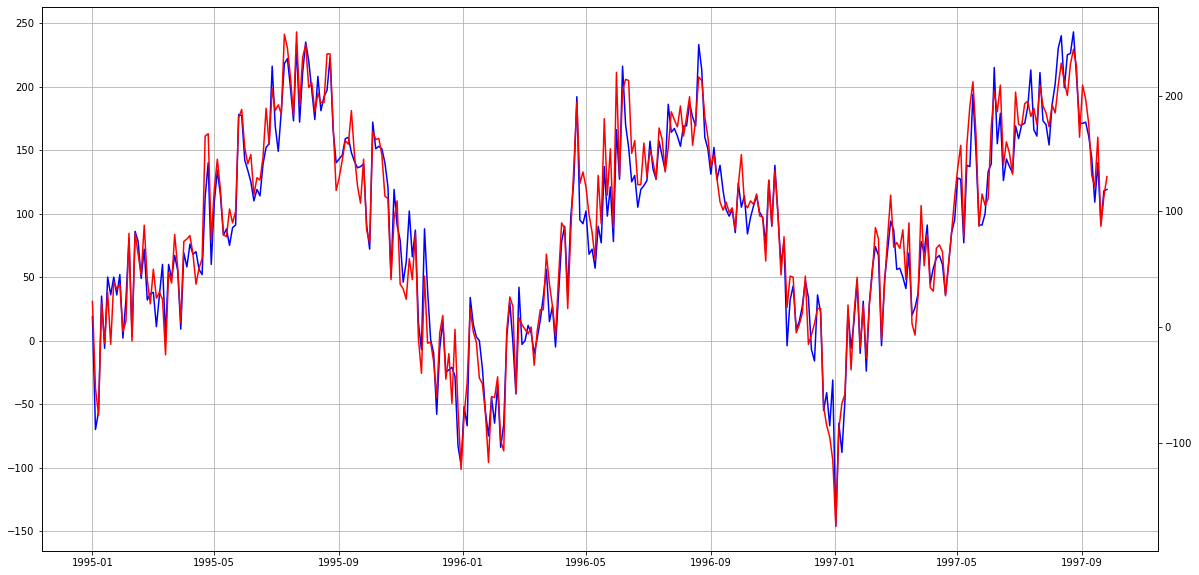

In [130]:
# plot some samples of daily temp
t_s_dates = just_temp_df.iloc[6666][:1000:3].index #sassumingly here to filter the temp points
plt.figure(figsize=(20,10))
just_temp_df.iloc[6666][td].plot(color='blue',grid=True)
just_temp_df.iloc[1111][td].plot(color='red',grid=True, secondary_y=True)

In [143]:
sum((just_temp_df.iloc[9845] -just_temp_df.iloc[1025])<0.05)

1879